This is the Curve Fitting Program

Generating initial parameters with differential evolution...
Generating initial parameters with brute force...
Initial parameters generated, fitting curve with initial parameters...
ANSWER -> [1.19312335e+00 1.84296742e+10 5.45558742e+00 7.98340757e-01
 6.60617618e+08 6.27803480e+00 9.96129285e-01 3.95058496e+09
 3.51621475e+00] [1.35685951e+00 9.84439022e+11 5.28153150e+00 9.85523509e-01
 2.94207774e+11 5.52294110e+00 1.11769092e+00 1.23744698e+11
 3.71710366e+00] [ 1.28038168e-01  2.53593944e+08 -8.62744836e-02  2.08995067e-01
 -8.95043059e+07 -1.22008238e+00  1.68680796e-01  1.85613061e+09
 -1.00374408e-01]
TRIES ->  760 430
Residual ->  123288774.43311241
Dif residual ->  359218486.41362524
Brute residual ->  36927294078.24867


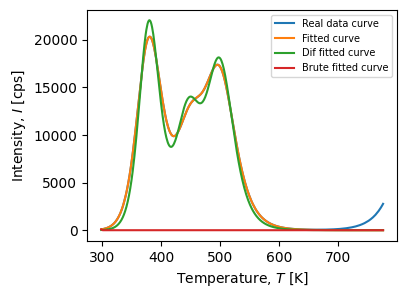

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit, differential_evolution, brute

# Constants
N = 1E5    # Total concentration of traps
n0 = N*(1/5)  # Initial concentration of electrons in traps
beta = 2.0    # Heating rate
k_J_per_K = 1.381e-23  # Boltzmann constant in J/K

#antiderivative function
def antiderivative(T_prime, E_J, beta, N):
    return k_J_per_K / E_J * (T_prime**2) * np.exp(-E_J / (k_J_per_K * T_prime))

def model(T, *args):
    #print("HERE -> ", args)
    #print("E_ev, S -> ", E_ev, S)
    res = np.zeros(T.size)
    for i in range(0, len(args), 3):
        E_ev = args[i]
        S = args[i + 1]
        nf = args[i + 2]
        n0 = N * nf
        E_J = E_ev * (1.602e-19)
        T0_antiderivative = antiderivative(T[0], E_J, beta, N)
        for j in range(0, T.size):
            integral_result = antiderivative(T[j], E_J, beta, N) - T0_antiderivative
            #print("HERE3 -> ", integral_result)
            numerator = n0**2 * S * np.exp(-E_J / (k_J_per_K * T[j]))
            #print("HERE4 -> ", numerator)
            denominator = N * (1 + (n0 * S) / (beta * N) * integral_result)**2 
            #print("HERE5 -> ", denominator)
            res[j] += numerator / denominator
    return res

def diff_model(x, T, intensity_values):
    #print("HERE2 -> ", x)
    #res = np.zeros(T.size)
    #for i in range(0, x.size, 3):
    #    E_ev = x[i]
    #    S = x[i + 1]
    #    nf = x[i + 2]
    #    res += model(T, E_ev, S, nf)
    res = model(T, *x)
    return np.sum((intensity_values - res)**2)

dif_bounds = (
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10)
)

#load main csv file
arr = np.transpose(np.loadtxt("data_multi-peak.csv", delimiter=",", skiprows=1))
arr[0] = arr[0] + np.ones(arr[0].size) * 273.15;
#e = 0.07 to 1.5
#s = 10^7 to 10^13
#N = 10^4 to 10^12

print("Generating initial parameters with differential evolution...")
res = differential_evolution(
    func = diff_model,
    bounds = dif_bounds,
    args = (arr[0], arr[1]),
    tol = 10000 #tol = 10000, safe value
)

print("Generating initial parameters with brute force...")
x0 = brute(
    func = diff_model,
    ranges = dif_bounds,
    args = (arr[0], arr[1]),
    Ns = 1
)

print("Initial parameters generated, fitting curve with initial parameters...")
initial_guess = res.x
popt, pcov, infodict, mesg, ier = curve_fit(
    f=model,
    xdata=arr[0],
    ydata=arr[1],
    p0 = initial_guess,
    full_output = True
)

print("ANSWER ->", popt, res.x, x0)
print("TRIES -> ", res.nfev, infodict["nfev"])

plt.figure(figsize=(4, 3))

fitted_intensity = model(arr[0], *popt)
dif_fitted_intensity = model(arr[0], *(res.x))
brute_fitted_intensity = model(arr[0], *x0)

residual = np.sum((arr[1] - fitted_intensity)**2)
dif_residual = np.sum((arr[1] - dif_fitted_intensity)**2)
brute_residual = np.sum((arr[1] - brute_fitted_intensity)**2)

print("Residual -> ", residual)
print("Dif residual -> ", dif_residual)
print("Brute residual -> ", brute_residual)

plt.plot(arr[0], arr[1], alpha=1, label = 'Real data curve')
plt.plot(arr[0], fitted_intensity, alpha=1, label = 'Fitted curve')
plt.plot(arr[0], dif_fitted_intensity, alpha=1, label = 'Dif fitted curve')
plt.plot(arr[0], brute_fitted_intensity, alpha=1, label = 'Brute fitted curve')
plt.xlabel('Temperature, $T$ [K]')
plt.ylabel('Intensity, $I$ [cps]')
plt.legend(fontsize=7, loc='best')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit, differential_evolution, brute

def minimums_maxes(initial_parameters):
    Es = []
    Ss = []
    nfs = []
    for i in range(0, initial_parameters.size, 3):
        Es.append(initial_parameters[i])
    for i in range(1, initial_parameters.size, 3):
        Ss.append(initial_parameters[i])
    for i in range(2, initial_parameters.size, 3):
        nfs.append(initial_parameters[i])
    return ([min(Es), min(Ss), min(nfs)], [max(Es), max(Ss), max(nfs)])
def generate_bounds(N, Eb, Sb, nfb):
    res = []
    for i in range(0, N):
        res.append(Eb)
        res.append(Sb)
        res.append(nfb)
    return res

class Model:
    def __init__(self, N, beta, k_J_per_K):
        self.N = N
        self.beta = beta
        self.k_J_per_K = k_J_per_K
    def evaluate(self, T, *args):
        #print(self, T, args)
        res = np.zeros(T.size)
        for i in range(0, len(args), 3):
            E_ev = args[i]
            S = args[i + 1]
            nf = args[i + 2]
            n0 = N * nf
            E_J = E_ev * (1.602e-19)
            T0_antiderivative = antiderivative(T[0], E_J, self.beta, self.N)
            for j in range(0, T.size):
                integral_result = antiderivative(T[j], E_J, self.beta, self.N) - T0_antiderivative
                numerator = n0**2 * S * np.exp(-E_J / (self.k_J_per_K * T[j]))
                denominator = self.N * (1 + (n0 * S) / (self.beta * self.N) * integral_result)**2 
                res[j] += numerator / denominator
        return res
    def residual(self, x, T, intensity_values):
        res = self.evaluate(T, *x)
        return np.sum((intensity_values - res)**2)

class Solver:
    def __init__(self, model, x_data, y_data):
        self.model = model
        self.x_data = x_data
        self.y_data = y_data
    def differential_evolution(self, bounds):
        res = differential_evolution(
            func = model.residual,
            bounds = bounds,
            args = (self.x_data, self.y_data),
            tol = 10000, #tol = 10000, safe value
            workers = 8
        )
        return res.x
    def brute_force(self, bounds, Ns):
        x0 = brute(
            func = model.residual,
            ranges = bounds,
            args = (self.x_data, self.y_data),
            Ns = Ns
        )
        return x0
    def curve_fit(self, initial_guess, bounds = None):
        if(bounds != None):
            popt, pcov, infodict, mesg, ier = curve_fit(
                f=model.evaluate,
                xdata=self.x_data,
                ydata=self.y_data,
                p0 = initial_guess,
                bounds = bounds,
                full_output = True,
                maxfev = 1000000
            )
        else:
            popt, pcov, infodict, mesg, ier = curve_fit(
                f=model.evaluate,
                xdata=self.x_data,
                ydata=self.y_data,
                p0 = initial_guess,
                full_output = True,
                maxfev = 1000000
            )
        return popt
class Plotter:
    def __init__(self):
        plt.figure(figsize=(4, 3))
    def plot(self, x_data, y_data, alpha, label):
        plt.plot(x_data, y_data, alpha=alpha, label = label)
bounds = (
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10),
    (0.07, 1.5),
    (10e8, 10e11),
    (1, 10)
)
    
bounds = generate_bounds(
    N = 8,
    Eb = (0.9,2.1),
    Sb = (1.6e11, 1e12),
    nfb = (0.9, 2)
)

print(bounds)
    

arr = np.transpose(np.loadtxt("real_data.csv", delimiter=",", skiprows=1))
x_data = arr[0] + np.ones(arr[0].size) * 273.15
y_data = arr[1]

print("Creating model...")
model = Model(
    N = 1E5,    # Total concentration of traps
    beta = 2.0,    # Heating rate
    k_J_per_K = 1.381e-23  # Boltzmann constant in J/K
)

print("Creating solver...")
solver = Solver(
    model = model,
    x_data = x_data,
    y_data = y_data
)  

print("Generating initial parameters with differential evolution...")
initial_parameters = solver.differential_evolution(
    bounds = bounds
)

print("Fitting curve with initial parameters...")
answer = solver.curve_fit(
    initial_guess = initial_parameters
)
print(answer)
print(minimums_maxes(initial_parameters))

print("Creating plotter...")
plotter = Plotter()

print("Plotting...")
plotter.plot(
    x_data = x_data,
    y_data = y_data,
    alpha = 1,
    label = 'Real data curve'
)

plotter.plot(
    x_data = x_data, 
    y_data = model.evaluate(x_data, *initial_parameters),
    alpha = 1,
    label = 'Initial data curve'
)

plotter.plot(
    x_data = x_data,
    y_data = model.evaluate(x_data, *answer),
    alpha = 1,
    label = 'Fitted data curve'
)

plt.xlabel('Temperature, $T$ [K]')
plt.ylabel('Intensity, $I$ [cps]')
plt.legend(fontsize=7, loc='best')
plt.show()

[(0.9, 2.1), (160000000000.0, 1000000000000.0), (0.9, 2), (0.9, 2.1), (160000000000.0, 1000000000000.0), (0.9, 2), (0.9, 2.1), (160000000000.0, 1000000000000.0), (0.9, 2), (0.9, 2.1), (160000000000.0, 1000000000000.0), (0.9, 2), (0.9, 2.1), (160000000000.0, 1000000000000.0), (0.9, 2), (0.9, 2.1), (160000000000.0, 1000000000000.0), (0.9, 2), (0.9, 2.1), (160000000000.0, 1000000000000.0), (0.9, 2), (0.9, 2.1), (160000000000.0, 1000000000000.0), (0.9, 2)]
Creating model...
Creating solver...
Generating initial parameters with differential evolution...


C:\Users\arjun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
